In [11]:
#Importing Libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import plot

#for offline plotting
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
df = pd.read_csv("C:/Users/sonin/OneDrive/Desktop/Projects/Stock_price_prediction/TSLA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-08-15,301.786682,313.133331,301.230011,309.320007,309.320007,89359200
1,2022-08-16,311.666656,314.666656,302.883331,306.563324,306.563324,88136400
2,2022-08-17,303.396667,309.656677,300.033325,303.996674,303.996674,68766000
3,2022-08-18,306.000000,306.500000,301.853333,302.869995,302.869995,47500500
4,2022-08-19,299.000000,300.359985,292.500000,296.666656,296.666656,61395300


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       250 non-null    object 
 1   Open       250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Close      250 non-null    float64
 5   Adj Close  250 non-null    float64
 6   Volume     250 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.8+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
print(f'Dataframe contains stock price between {df.Date.min()} {df.Date.max()}')
print(f'Total days = {(df.Date.max()- df.Date.min()).days} days')

Dataframe contains stock price between 2022-08-15 00:00:00 2023-08-11 00:00:00
Total days = 361 days


In [7]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,250,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,2023-02-11 03:44:38.400000,211.199600,215.694400,206.270920,211.041120,211.041120,1.256174e+08
min,2022-08-15 00:00:00,103.000000,111.750000,101.809998,108.099998,108.099998,4.186470e+07
25%,2022-11-10 06:00:00,176.367504,182.379997,172.502499,178.187496,178.187496,8.984285e+07
50%,2023-02-11 12:00:00,198.234993,202.845001,192.885002,197.474998,197.474998,1.205918e+08
75%,2023-05-11 18:00:00,255.780006,261.362503,251.834999,256.742508,256.742508,1.600711e+08
max,2023-08-11 00:00:00,311.666656,314.666656,305.579987,309.320007,309.320007,3.065906e+08
std,NaN,51.381149,51.740781,50.881852,51.226539,51.226539,4.883101e+07


<Axes: >

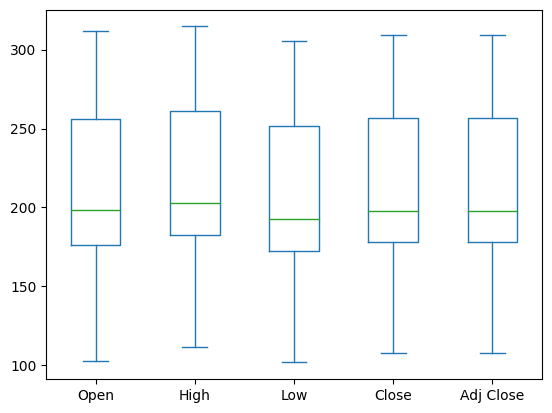

In [9]:
df[['Open','High','Low','Close','Adj Close']].plot(kind='box')

In [14]:
#setting the layout for our plot
layout = go.Layout(
    title='Stock Prices of TESLA',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
nb_data = [{'x':df['Date'],'y':df['Close']}]
plot=go.Figure(data=nb_data, layout=layout)

In [15]:
#plot(plot) #plottinf offline
iplot(plot)

In [16]:
closed_prices = df["Close"]
closed_prices

0      309.320007
1      306.563324
2      303.996674
3      302.869995
4      296.666656
          ...    
245    251.449997
246    249.699997
247    242.190002
248    245.339996
249    242.649994
Name: Close, Length: 250, dtype: float64

In [17]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [18]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [19]:
X = np.array(X)[... , None]
y = np.array(y)[... , None]
    
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [20]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
model = Model(1 , 64)

In [21]:
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

In [23]:
num_epochs = 300

for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

10 epoch loss 0.005906892
20 epoch loss 0.0055249175
30 epoch loss 0.00510543
40 epoch loss 0.00464708
50 epoch loss 0.0041536903
60 epoch loss 0.0037157168
70 epoch loss 0.0034890594
80 epoch loss 0.0033189515
90 epoch loss 0.0031476046
100 epoch loss 0.0029934207
110 epoch loss 0.0028430738
120 epoch loss 0.0026968124
130 epoch loss 0.002552627
140 epoch loss 0.002410512
150 epoch loss 0.0022750804
160 epoch loss 0.0021589298
170 epoch loss 0.0020816
180 epoch loss 0.0021435565
190 epoch loss 0.0020576376
200 epoch loss 0.00200411
210 epoch loss 0.0019752013
220 epoch loss 0.0019526249
230 epoch loss 0.0019302496
240 epoch loss 0.001907269
250 epoch loss 0.0018847537
260 epoch loss 0.0018625767
270 epoch loss 0.0018409841
280 epoch loss 0.0021594015
290 epoch loss 0.0019164378


In [24]:
model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())

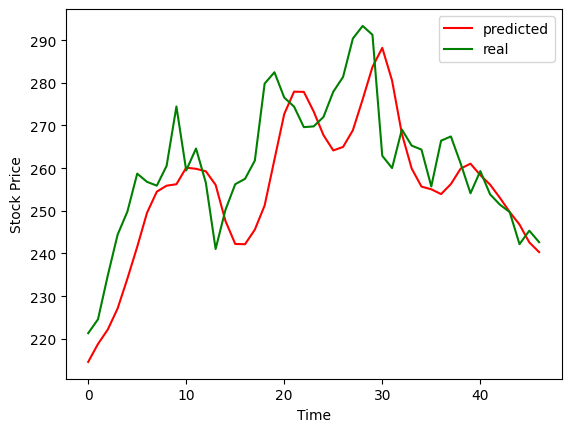

In [27]:
plt.plot(pred.squeeze() , color = "red" , label = "predicted")
plt.plot(real.squeeze() , color = "green" , label = "real")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
